<a href="https://colab.research.google.com/github/jiwonlydia/return_prediction/blob/main/0615_data%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

공식 깃허브: https://github.com/LouisChen1992/Deep_Learning_Asset_Pricing

# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = '/content/drive/MyDrive/research/return_prediction/dlap'
os.chdir(path)

In [ ]:
pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Config

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from src.data import data_layer
from src.utils import deco_print

1.14.0


In [ ]:
#### Delete all flags before declare #####

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

- tensorflow의 flag란?
- https://daeson.tistory.com/256

In [ ]:
del_all_flags(tf.flags.FLAGS)
tf.flags.DEFINE_string("f", "", "kernel") # 주피터 노트북에서 돌릴땐 이 코드 추가해야 돌아감

tf.flags.DEFINE_string('config', path+'/config/config.json', 'Path to the file with configurations')
tf.flags.DEFINE_string('logdir', '', 'Path to save logs and checkpoints')

tf.flags.DEFINE_integer('saveBestFreq', -1, 'Frequency to save best model')
tf.flags.DEFINE_boolean('printOnConsole', True, 'Print on console or not')
tf.flags.DEFINE_boolean('saveLog', True, 'Save log or not')
tf.flags.DEFINE_integer('printFreq', 128, 'Frequency to print on console')
tf.flags.DEFINE_integer('ignoreEpoch', 64, 'Ignore first several epochs')

FLAGS = tf.flags.FLAGS

In [ ]:
with open(FLAGS.config, 'r') as file:
    config = json.load(file)
    if not 'macro_idx' in config:
        config['macro_idx'] = None

deco_print('Read the following in config: ')
print(json.dumps(config, indent=4))

>==================> Read the following in config: 
{
    "learning_rate": 0.001,
    "num_layers_moment": 0,
    "num_units_rnn": [
        8
    ],
    "macro_feature_file_test": "datasets/macro/macro_test.npz",
    "optimizer": "Adam",
    "macro_feature_file": "datasets/macro/macro_train.npz",
    "use_rnn": true,
    "weighted_loss": true,
    "hidden_dim": [
        64,
        64
    ],
    "cell_type_rnn_moment": "lstm",
    "cell_type_rnn": "lstm",
    "macro_feature_file_valid": "datasets/macro/macro_valid.npz",
    "num_epochs_moment": 64,
    "tSize": 192,
    "tSize_valid": 60,
    "tSize_test": 60,
    "individual_feature_dim": 48,
    "macro_feature_dim": 127,
    "num_condition_moment": 8,
    "loss_factor": 1.0,
    "num_layers_rnn_moment": 1,
    "individual_feature_file_valid": "datasets/char/Char_valid.npz",
    "num_epochs": 1024,
    "individual_feature_file": "datasets/char/Char_train.npz",
    "num_units_rnn_moment": [
        32
    ],
    "num_epochs_unc": 256

# datalayer

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pathIndividualFeature = config['individual_feature_file'] ; print(pathIndividualFeature)
pathMacroFeature = pathMacroFeature=config['macro_feature_file'] ; print(pathMacroFeature)
macroIdx = config['macro_idx'] ; print(macroIdx)

datasets/char/Char_train.npz
datasets/macro/macro_train.npz
None


In [ ]:
dl = data_layer.DataInRamInputLayer(
		config['individual_feature_file'],
		pathMacroFeature=config['macro_feature_file'],
		macroIdx=config['macro_idx'],
		normalizeMacroFeature=False) # 0 ~ 177

for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
	# print(R[mask])
	print(R.shape)
	print(I_macro.shape)

(240, 3686)
(240, 178)


In [ ]:
I[:,0].shape

(240, 46)

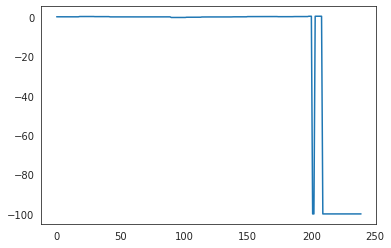

In [ ]:
plt.plot(I[:,0,0])

In [ ]:
plt.plot(R[mask])

## Load Individual Feature

In [ ]:
_UNK = -99.99
tmp_ind = np.load(pathIndividualFeature) 
data = tmp_ind['data']
_return = data[:,:,0] # (240, 3686)
print(_return.shape)
_individualFeature = data[:,:,1:] # (240, 3686, 46)
_mask = (_return != _UNK) # shape (240, 3686), boolean(True/False)

In [ ]:
_return

In [ ]:
_return[:,0].shape

In [ ]:
_return[:,0]

In [ ]:
plt.plot(pd.DataFrame(_return[:,0]))

In [ ]:
print(_individualFeature[:,0,:].shape)
_individualFeature[:,0,:]

In [ ]:
pd.DataFrame(_return.reshape(-1))

In [ ]:
pd.DataFrame(_individualFeature.reshape(240*3686, 46))

In [ ]:
def _create_var_idx_associations(varList):
		idx2var = {idx:var for idx, var in enumerate(varList)}
		var2idx = {var:idx for idx, var in enumerate(varList)}
		return idx2var, var2idx

def _load_individual_feature(pathIndividualFeature):
    _UNK = -99.99
    tmp = np.load(pathIndividualFeature) # 'datasets/char/Char_train.npz'
    data = tmp['data']
    
    ### Data Stored Here		
    _return = data[:,:,0] # shape (240, 3686)
    _individualFeature = data[:,:,1:]
    _mask = (_return != _UNK) # shape (240, 3686), boolean(True/False)

    ### Dictionary
    _idx2date, _date2idx = _create_var_idx_associations(tmp['date'])
    _idx2var, _var2idx = _create_var_idx_associations(tmp['variable'][1:])
    _dateCount, _permnoCount, _varCount = data.shape
    _varCount -= 1

## Load Macro feature

In [ ]:
tmp_mac = np.load(pathMacroFeature)
macro_idx = np.arange(len(tmp_mac['variable']))

In [ ]:
for i in tmp_mac.items():
    print(i)

In [ ]:
_macroFeature = tmp_mac['data'][:,macro_idx] # (240, 178)
_macroFeature.shape 

(240, 178)

In [ ]:
_macroFeature.max()

302.0

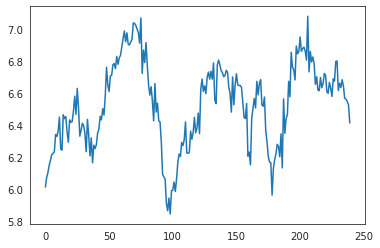

In [ ]:
plt.plot(pd.DataFrame(_macroFeature[:,50]))

In [ ]:
_macroFeature[:,0].shape

(240,)

In [ ]:
k = 10
plt.figure(figsize=(10,5*k))
for i, col in enumerate(df_mac.columns[:k]):
    plt.subplot(k, 1, i+1) 
    plt.plot(df_mac[col])
    plt.title('%s' %col)
    

# LoadData

In [ ]:
class LoadData:
    def __init__(self, pathIndividualFeature, pathMacroFeature):
        self._UNK = -99.99
        self._load_individual_feature(pathIndividualFeature)
        self._load_macro_feature(pathMacroFeature)		

    def _load_individual_feature(self, pathIndividualFeature):
        tmp = np.load(pathIndividualFeature, allow_pickle=True) # 'datasets/char/Char_train.npz'
        data = tmp['data']

        ### Data Stored Here		
        self._return = data[:,:,0].astype('float32') 
        self._individualFeature = data[:,:,1:].astype('float32')
        self._mask = (self._return != self._UNK)

    def _load_macro_feature(self, pathMacroFeature):
        tmp = np.load(pathMacroFeature, allow_pickle=True)
        macro_idx = np.arange(len(tmp['variable']))
        self._macroFeature = tmp['data'][:,macro_idx].astype('float32')


    def iterateOneEpoch(self, subEpoch=False):
        if subEpoch:
            for _ in range(subEpoch):
                yield self._macroFeature, self._individualFeature, self._return, self._mask
        else:
            yield self._macroFeature, self._individualFeature, self._return, self._mask

In [ ]:
dl = LoadData(
		pathIndividualFeature='my_char_train.npz',
        pathMacroFeature='my_macro_train.npz')

dl_valid = LoadData(
		pathIndividualFeature='my_char_valid.npz',
        pathMacroFeature='my_macro_valid.npz')

dl_test = LoadData(
		pathIndividualFeature='my_char_test.npz',
        pathMacroFeature='my_macro_test.npz')

In [ ]:
for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
    print('dl')
    print(I_macro.shape)
    print(I.shape)

for _, (I_macro, I, R, mask) in enumerate(dl_valid.iterateOneEpoch(subEpoch=False)):
    print('dl_valid')
    print(I_macro.shape)
    print(I.shape)

for _, (I_macro, I, R, mask) in enumerate(dl_test.iterateOneEpoch(subEpoch=False)):
    print('dl_test')
    print(I_macro.shape)
    print(I.shape)

dl
(192, 127)
(192, 3194, 48)
dl_valid
(60, 127)
(60, 1313, 48)
dl_test
(60, 127)
(60, 1386, 48)


In [ ]:
# dl = LoadData(
# 		pathIndividualFeature='datasets/char/Char_train.npz',
#         pathMacroFeature='datasets/macro/macro_train.npz')

# for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
#     print(I_macro.shape)
#     print(I_macro)

In [ ]:
# print((float("inf") in I_macro)|(float("-inf") in I_macro))
# print((float("inf") in I)|(float("-inf") in I))
# print((float("inf") in R)|(float("-inf") in R))

# Model
---
- https://wdprogrammer.tistory.com/34

In [ ]:
from tensorflow.python.ops.rnn_cell import BasicRNNCell
from tensorflow.python.ops.rnn_cell import GRUCell
from tensorflow.python.ops.rnn_cell import LSTMCell
from tensorflow.python.ops.rnn_cell import DropoutWrapper
from tensorflow.python.ops.rnn_cell import MultiRNNCell

def create_rnn_cell(cell_type, num_units, num_layers=1, dp_input_keep_prob=1.0, dp_output_keep_prob=1.0):
	def single_cell(num_units):
		if cell_type == 'rnn':
			cell_class = BasicRNNCell
		elif cell_type == 'gru':
			cell_class = GRUCell
		elif cell_type == 'lstm':
			cell_class = LSTMCell
		else:
			raise ValueError('Cell Type Not Supported! ')

		if dp_input_keep_prob != 1.0 or dp_output_keep_prob != 1.0:
			return DropoutWrapper(cell_class(num_units=num_units),
				input_keep_prob=dp_input_keep_prob,
				output_keep_prob=dp_output_keep_prob)
		else:
			return cell_class(num_units=num_units)

	assert(len(num_units) == num_layers)
	if num_layers > 1:
		return MultiRNNCell([single_cell(num_units[i]) for i in range(num_layers)])
	else:
		return single_cell(num_units[0])

In [ ]:
def initial_state_size(cell_type, num_units):
	state_size = sum(num_units)
	return state_size * 2
	

In [ ]:
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import LSTMStateTuple

class Model():
    def __init__(self, model_params, tSize, force_var_reuse=False, global_step=None):
        # super(Model, self).__init__(model_params, global_step)
        self._force_var_reuse = force_var_reuse
        self.model_params = model_params
        self._global_step = global_step

        # ---- placeholders ---- #
        self._tSize = tSize
        self._macro_feature_dim = self.model_params['macro_feature_dim']
        self._individual_feature_dim = self.model_params['individual_feature_dim']
        self._I_macro_placeholder = tf.placeholder(dtype=tf.float32, shape=[self._tSize, self._macro_feature_dim], name='macroFeaturePlaceholder')
        self._I_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, None, self._individual_feature_dim], name='individualFeaturePlaceholder')
        self._R_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, None], name='returnPlaceholder')
        self._mask_placeholder = tf.placeholder(dtype=tf.bool, shape=[None, None], name='maskPlaceholder')
        self._dropout_placeholder = tf.placeholder_with_default(1.0, shape=[], name='Dropout')
        self._nSize = tf.shape(self._R_placeholder)[1]
        
        
        # self._state_size = initial_state_size(self.model_params['cell_type_rnn'], self.model_params['num_units_rnn'])
        # self._initial_state_placeholder = tf.placeholder(dtype=tf.float32, shape=[1, self._state_size])
        # splits = [2*unit for unit in self.model_params['num_units_rnn']]
        # self._initial_state = tuple([LSTMStateTuple(*tf.split(value=layer_state, num_or_size_splits=2, axis=1))
        #         for layer_state in tf.split(value=self._initial_state_placeholder, num_or_size_splits=splits, axis=1)])
        # self._initial_state = self._initial_state[0]

        
        ### rnn input ###
        _I_macro_placeholder = self._I_macro_placeholder ; print('_I_macro_placeholder', _I_macro_placeholder.shape) # (240, 178)
        self._rnn_input = tf.expand_dims(self._I_macro_placeholder, axis=0) 
        rnn_input = self._rnn_input ; print('rnn_input: ', rnn_input.shape) # (1, 240, 178)

        with tf.variable_scope(name_or_scope='Model_Layer', reuse=self._force_var_reuse):
            self.build()
        


    def build(self):

        with tf.variable_scope('RNN_Layer'):
            rnn_cell = create_rnn_cell(
                        cell_type=self.model_params['cell_type_rnn'], # lstm
                        num_units=self.model_params['num_units_rnn'], # 4
                        num_layers=self.model_params['num_layers_rnn'], # 1
                        dp_input_keep_prob=self._dropout_placeholder,
                        dp_output_keep_prob=1.0
                        )

            rnn_outputs, rnn_state = tf.nn.dynamic_rnn(
                        cell=rnn_cell,
                        inputs=self._rnn_input,
                        # initial_state=self._initial_state,
                        dtype=tf.float32)
            self._rnn_state = rnn_state
            print('rnn_outputs: ', rnn_outputs.shape) # (1, 240, 4)
            
            self._macro_nn_input = tf.squeeze(rnn_outputs, axis=0) # RNN 통과해서 나온 macro 변수들의 hidden state?
            _macro_nn_input = self._macro_nn_input ; print('_macro_nn_input', _macro_nn_input.shape) # (240, 4)

        with tf.variable_scope('NN_Layer'):
            I_macro_tile = tf.tile(tf.expand_dims(self._macro_nn_input, axis=1), [1,self._nSize,1]) # T * N * macro_feature_dim (240, ?, 4)
            print('I_macro_tile', I_macro_tile.shape)
            I_macro_masked = tf.boolean_mask(I_macro_tile, mask=self._mask_placeholder) # (?, 4)
            print('I_macro_masked', I_macro_masked.shape)
            I_masked = tf.boolean_mask(self._I_placeholder, mask=self._mask_placeholder) # (?, 46)
            print('I_masked', I_masked.shape)
            I_concat = tf.concat([I_masked, I_macro_masked], axis=1) # None * (macro_feature_dim + individual_feature_dim)
            print('I_concat', I_concat.shape) # (?, 50)
            R_masked = tf.boolean_mask(self._R_placeholder, mask=self._mask_placeholder)
            print('R_masked', R_masked.shape) # (?,)

            h_l = I_concat # 이게 macro와 firm-spec.이 합쳐진 것

            for l in range(self.model_params['num_layers']):
                with tf.variable_scope('dense_layer_%d' %l):
                    layer_l = Dense(units=self.model_params['hidden_dim'][l], activation=tf.nn.relu)
                    h_l = layer_l(h_l) # macro와 firm-spec.이 합쳐진 것이 Dense layer를 통과함 
                    h_l = tf.nn.dropout(h_l, self._dropout_placeholder)

            with tf.variable_scope('last_dense_layer'):
                layer = Dense(units=1) # 마지막 dense layer이므로 output unit 개수가 1
                R_pred = layer(h_l)
                self._R_pred = tf.reshape(R_pred, shape=[-1])

        self._loss = tf.reduce_mean(tf.square(R_masked - self._R_pred))
        self._train_model_op = tf.contrib.layers.optimize_loss(
                                                                loss=self._loss,
                                                                global_step=self._global_step,
                                                                learning_rate=0.001,
                                                                optimizer="Adam")


    def train(self, sess, dl, dl_valid, model_valid, dl_test=None, model_test=None,
              printOnConsole=True, printFreq=10):
        
        best_valid_loss = float('inf')
        sharpe_train = [] ; r2_train = []
        sharpe_valid = [] ; r2_valid = []

        ### evaluate test data
        evaluate_test_data = False
        if dl_test is not None:
            evaluate_test_data = True
            sharpe_test = [] ; r2_test = []


        ###### initialize variables ######
        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        sess.run(init_g)
        sess.run(init_l)

        for epoch in range(100):
            for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):

                fetches = [self._train_model_op]
                feed_dict = {self._I_macro_placeholder:I_macro,
                            self._I_placeholder:I,
                            self._R_placeholder:R,
                            self._mask_placeholder:mask,
                            self._dropout_placeholder:self.model_params['dropout']
                            }
                
                sess.run(fetches=fetches, feed_dict=feed_dict)
            
            ### evaluate train loss / R2
            train_epoch_loss = self.evaluate_loss(sess, dl)
            train_epoch_r2 = self.evaluate_r_sq(sess, dl)
            r2_train.append(train_epoch_r2)

            ### evaluate valid loss / R2
            valid_epoch_loss = model_valid.evaluate_loss(sess, dl_valid)
            valid_epoch_r2 = model_valid.evaluate_r_sq(sess, dl_valid)
            r2_valid.append(valid_epoch_r2)
            
            ### evaluate test loss / R2
            if evaluate_test_data:
                test_epoch_loss = model_test.evaluate_loss(sess, dl_test)
                test_epoch_r2 = model_test.evaluate_r_sq(sess, dl_test)
                r2_test.append(test_epoch_r2)

            ### print loss / R2
            if printOnConsole and epoch % printFreq == 0:
                print('\n\n')
                deco_print('Doing epoch %d' %epoch)
                if evaluate_test_data:
                    deco_print('Epoch %d train/valid/test loss: %0.4f/%0.4f/%0.4f' %(epoch, train_epoch_loss, valid_epoch_loss, test_epoch_loss))
                    deco_print('Epoch %d train/valid/test R-Squared: %0.4f/%0.4f/%0.4f' %(epoch, train_epoch_r2, valid_epoch_r2, test_epoch_r2))
        
                else:
                    deco_print('Epoch %d train/valid loss: %0.4f/%0.4f' %(epoch, train_epoch_loss, valid_epoch_loss))
                    deco_print('Epoch %d train/valid R-Squared: %0.4f/%0.4f' %(epoch, train_epoch_r2, valid_epoch_r2))
            
            ### save epoch
            if valid_epoch_loss < best_valid_loss:
                best_valid_loss = valid_epoch_loss
                if printOnConsole and epoch % printFreq == 0:
                    deco_print('Saving current best checkpoint')
                # saver.save(sess, save_path=os.path.join(logdir, 'model-best'))
        
        if evaluate_test_data:
            return r2_train, r2_valid, r2_test
        else:
            return r2_train, r2_valid


    def evaluate_loss(self, sess, dl):
        for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
            feed_dict = {self._I_macro_placeholder:I_macro,
                        self._I_placeholder:I,
                        self._R_placeholder:R,
                        self._mask_placeholder:mask,
                        self._dropout_placeholder:1.0
                            }
            loss, = sess.run([self._loss], feed_dict=feed_dict)
        return loss

    def getPrediction(self, sess, dl):
        for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
            feed_dict = {self._I_macro_placeholder:I_macro,
                        self._I_placeholder:I,
                        self._R_placeholder:R,
                        self._mask_placeholder:mask,
                        self._dropout_placeholder:1.0}
            R_pred, = sess.run(fetches=[self._R_pred], feed_dict=feed_dict)
        return R_pred

    def evaluate_r_sq(self, sess, dl):
        R_pred = self.getPrediction(sess, dl)
        for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
            r_sq = 1 - ( sum((R[mask] - R_pred)**2) / sum(R[mask]**2) )
        return r_sq

    def evaluate_sth(self, sess, dl):
        for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
            feed_dict = {self._I_macro_placeholder:I_macro,
                        self._I_placeholder:I,
                        self._R_placeholder:R,
                        self._mask_placeholder:mask,
                        self._dropout_placeholder:1.0}
            sth = sess.run(fetches=[self._rnn_state], feed_dict=feed_dict)
        return sth


# Train

In [ ]:
config

{'cell_type_rnn': 'lstm',
 'cell_type_rnn_moment': 'lstm',
 'dropout': 0.95,
 'hidden_dim': [64, 64],
 'hidden_dim_moment': [],
 'individual_feature_dim': 48,
 'individual_feature_file': 'datasets/char/Char_train.npz',
 'individual_feature_file_test': 'datasets/char/Char_test.npz',
 'individual_feature_file_valid': 'datasets/char/Char_valid.npz',
 'learning_rate': 0.001,
 'loss_factor': 1.0,
 'macro_feature_dim': 127,
 'macro_feature_file': 'datasets/macro/macro_train.npz',
 'macro_feature_file_test': 'datasets/macro/macro_test.npz',
 'macro_feature_file_valid': 'datasets/macro/macro_valid.npz',
 'macro_idx': None,
 'num_condition_moment': 8,
 'num_epochs': 1024,
 'num_epochs_moment': 64,
 'num_epochs_unc': 256,
 'num_layers': 2,
 'num_layers_moment': 0,
 'num_layers_rnn': 1,
 'num_layers_rnn_moment': 1,
 'num_units_rnn': [8],
 'num_units_rnn_moment': [32],
 'optimizer': 'Adam',
 'sub_epoch': 4,
 'tSize': 192,
 'tSize_test': 60,
 'tSize_valid': 60,
 'use_rnn': True,
 'weighted_loss': T

In [ ]:
model_params = config
tf.reset_default_graph()
global_step = tf.train.get_or_create_global_step()
model = Model(model_params=config, tSize=config['tSize'], global_step=global_step)
model_valid = Model(model_params=config, tSize=config['tSize_valid'], force_var_reuse=True, global_step=global_step)
model_test = Model(model_params=config, tSize=config['tSize_test'], force_var_reuse=True, global_step=global_step)

_I_macro_placeholder (192, 127)
rnn_input:  (1, 192, 127)
rnn_outputs:  (1, 192, 8)
_macro_nn_input (192, 8)
I_macro_tile (192, ?, 8)
I_macro_masked (?, 8)
I_masked (?, 48)
I_concat (?, 56)
R_masked (?,)
_I_macro_placeholder (60, 127)
rnn_input:  (1, 60, 127)
rnn_outputs:  (1, 60, 8)
_macro_nn_input (60, 8)
I_macro_tile (60, ?, 8)
I_macro_masked (?, 8)
I_masked (?, 48)
I_concat (?, 56)
R_masked (?,)
_I_macro_placeholder (60, 127)
rnn_input:  (1, 60, 127)
rnn_outputs:  (1, 60, 8)
_macro_nn_input (60, 8)
I_macro_tile (60, ?, 8)
I_macro_masked (?, 8)
I_masked (?, 48)
I_concat (?, 56)
R_masked (?,)


In [ ]:
sess = tf.Session()
r2_train, r2_valid = model.train(sess, dl, dl_valid, model_valid)




>==================> Doing epoch 0
>==================> Epoch 0 train/valid loss: 0.0488/0.0405
>==================> Epoch 0 train/valid R-Squared: -1.7135/-4.2752
>==================> Saving current best checkpoint


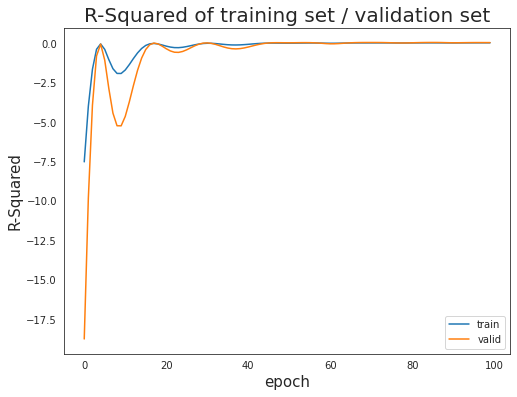

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(r2_train, label='train')
plt.plot(r2_valid, label='valid')
plt.xlabel('epoch', fontsize=15)
plt.ylabel('R-Squared', fontsize=15)
plt.title('R-Squared of training set / validation set', fontsize=20)
plt.legend()
plt.show()

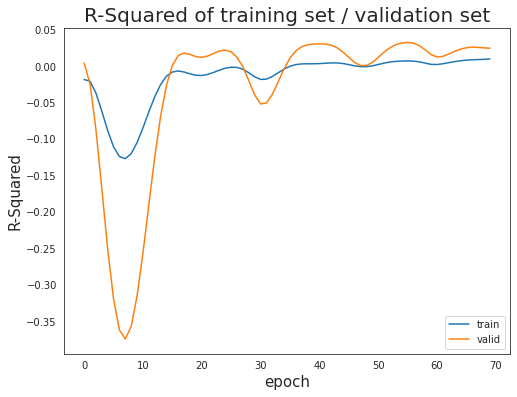

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(r2_train[30:], label='train')
plt.plot(r2_valid[30:], label='valid')
plt.xlabel('epoch', fontsize=15)
plt.ylabel('R-Squared', fontsize=15)
plt.title('R-Squared of training set / validation set', fontsize=20)
plt.legend()
plt.show()
